# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy as sc

import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

from time import time
from sklearn import cluster
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state, check_array, deprecated
from sklearn.utils.extmath import logsumexp
from sklearn.utils.validation import check_is_fitted

EPS = np.finfo(float).eps

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [2]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры  - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("v.nazarov") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [4]:
#Gaussian Mixture Model clustering
#max_aposteriori = k

class Clustering:
    
    def __init__(self, n_components=2, verbose=0, tol=1e-3, min_covar=1e-3, max_iter=100):
        
        self.n_components = n_components # Number of gaussian mixture components (features)
        self.tol = tol                   # Tolerance parameter of convergence
        self.min_covar = min_covar       # Floor on the diagonal of the cov matr to prevent overfitting
        self.max_iter = max_iter         # Maximal number of iterations
        self.verbose = verbose           # Verbose output: print all information if equals to 1
        
        if n_components < 1:
            raise ValueError('GMM estimation requires at least one component.')            
        elif tol > 1e-3:
            raise ValueError('GMM estimation requires tolerance to be smaller than 1e-3 or equal.')
        elif min_covar > 1e-3:
            raise ValueError('GMM estimation requires min_covar to be smaller than 1e-3 or equal.')
        elif max_iter > 500 or max_iter < 100:
            raise ValueError('GMM estimation requires maximal number of iterations in range of [0, 500].')
        elif not (verbose == 0 or verbose == 1):
            raise ValueError('GMM estimation requires verbose parameter to be equal 0 or 1.')
        return
    
    def _log_multivariate_normal_density(self, X, means, covars, min_covar=1.e-7):
        """
        Log probability = log (f), where
        f = 1/(2PI)^(n/2) * 1/|covars|^(1/2) * exp[-0.5 (x-mu)^T covars^-1 (x-mu)].
        """
        n_samples, n_dim = X.shape
        nmix = len(means)
        log_prob = np.empty((n_samples, nmix))
        for c, (mu, cv) in enumerate(zip(means, covars)):
            try:
                cv_chol = linalg.cholesky(cv)
            except linalg.LinAlgError:
                # The model is most probably stuck in a component with too
                # few observations, we need to reinitialize this components
                try:
                    cv_chol = linalg.cholesky(cv + min_covar * np.eye(n_dim))
                except linalg.LinAlgError:
                    raise ValueError("'covars' must be symmetric, positive-definite")

            cv_log_det = 2 * np.sum(np.log(np.diagonal(cv_chol)))
            cv_sol = sc.linalg.solve_triangular(cv_chol, (X - mu).T, lower=True).T
            log_prob[:, c] = - .5 * (np.sum(cv_sol ** 2, axis=1) + 
                                     n_dim * np.log(2 * np.pi) + cv_log_det)

        return log_prob
    
    def _do_estep(self, X):
        """
        Perform the Estep of the EM algorithm and
        return the posterior distribution (responsibilities) of each
        mixture component for each element of X.
        """
        check_is_fitted(self, 'means_')

        X = check_array(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
        if X.size == 0:
            return np.array([]), np.empty((0, self.n_components))
        if X.shape[1] != self.means_.shape[1]:
            raise ValueError('The shape of X  is not compatible with self')

        lpr = (self._log_multivariate_normal_density(X, self.means_, self.covars_) +
               np.log(self.weights_))
        
        logprob = logsumexp(lpr, axis=1)
        
        # gamma (z_k) = PI_k * N(x|mu_k, S_k) / sum[PI_j * N(x|mu_j, S_j)]
        responsibilities = np.exp(lpr - logprob[:, np.newaxis])
        
        return logprob, responsibilities
    
    def _do_mstep(self, X, responsibilities, min_covar=0):
        """
        Perform the Mstep of the EM algorithm and return the cluster weights.
        """
        # weights = N_k = sum [gamma(z_nk)]
        weights = responsibilities.sum(axis=0)
        # weighted_X_sum = sum [gamma(z_nk) * Xn]
        weighted_X_sum = np.dot(responsibilities.T, X)
        # inverse_weights = 1 / N_k 
        inverse_weights = 1.0 / (weights[:, np.newaxis] + 10 * EPS)

        # PI_k = N_k / N
        self.weights_ = (weights / (weights.sum() + 10 * EPS) + EPS)
        # mu_k = (1/N_k) * sum [gamma(z_nk) * Xn]
        self.means_   = weighted_X_sum * inverse_weights
        
        # S_k = (1/N_k) * sum [gamma(z_nk) (X_n - mu_k)^T (X_n - mu_k)]
        n_features = X.shape[1]
        cv = np.empty((self.n_components, n_features, n_features))
        for c in range(self.n_components):
            post = responsibilities[:, c]
            mu = self.means_[c]
            diff = X - mu
            with np.errstate(under='ignore'):
                # Underflow Errors in doing post * X.T are  not important
                avg_cv = np.dot(post * diff.T, diff) / (post.sum() + 10 * EPS)
            cv[c] = avg_cv + min_covar * np.eye(n_features)
        self.covars_  = cv
        
        return weights
    
    def fit(self, X, Y=None):
        """
        Estimate model parameters with the EM algorithm.
        -----------------------------------------------
        X : array_like, shape (n, n_features)
            List of n_features-dimensional data points.
            Each row corresponds to a single data point.
        """
        # Check input data shape
        if X.shape[0] < self.n_components:
            raise ValueError(
                'GMM estimation with %s components, but got only %s samples' %
                (self.n_components, X.shape[0]))

        max_log_prob = -np.infty

        if self.verbose > 0:
            print('Expectation-maximization algorithm started.')
            start_init_time = time()
        
        # Init means, weights, covars for initial state
        if not hasattr(self, 'means_'):
            self.means_ = cluster.KMeans(n_clusters=self.n_components).fit(X).cluster_centers_
            if self.verbose > 0:
                print('\tMeans have been initialized.')
        
        if not hasattr(self, 'weights_'):
            self.weights_ = np.tile(1.0 / self.n_components, self.n_components)
            if self.verbose > 0:
                print('\tWeights have been initialized.')

        if not hasattr(self, 'covars_'):
            cv = np.cov(X.T) + self.min_covar * np.eye(X.shape[1])
            if not cv.shape:
                cv.shape = (1, 1)
            self.covars_ = np.tile(cv, (self.n_components, 1, 1))
            if self.verbose > 0:
                print('\tCovariance matrices have been initialized.')

        # EM algorithms
        current_log_likelihood = None

        for i in xrange(self.max_iter):
            if self.verbose > 0:
                print('\tEM iteration ' + str(i + 1))
                start_iter_time = time()
            prev_log_likelihood = current_log_likelihood
            # Expectation step
            log_likelihoods, responsibilities = self._do_estep(X)
            current_log_likelihood = log_likelihoods.mean()

            # Check for convergence.
            if prev_log_likelihood is not None:
                change = abs(current_log_likelihood - prev_log_likelihood)
                if self.verbose > 0:
                    print('\t\tChange: ' + str(change))
                if change < self.tol:
                    if self.verbose > 0:
                        print('\t\tEM algorithm converged.')
                    break

            # Maximization step
            self._do_mstep(X, responsibilities, self.min_covar)
            if self.verbose > 0:
                print('\t\tEM iteration ' + ' took {0:.5f}s'.format(
                    time() - start_iter_time))
        
        if self.verbose > 0:
            print('\tInitialization ' + ' took {0:.5f}s'.format(
                time() - start_init_time))
        
        return responsibilities
    
    def predict(self, X):
        """
        Predict label for data.
        """
        logprob, responsibilities = self.score_samples(X)
        return responsibilities.argmax(axis=1)
    
    def fit_predict(self, X, Y=None):
        """
        Fit and then predict labels for data.
        """
        return self.fit(X, Y).argmax(axis=1)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

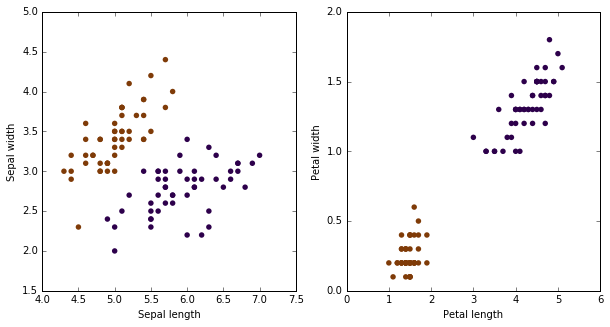

In [5]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [6]:
pred_iris = Clustering().fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [7]:
def quality(x, y, k):
    x_len = len(x)
    dist_matrix = np.zeros((x_len, x_len))
    for i in range(x_len):
        for j in range(i + 1, x_len):
            dist_matrix[i, j] = sc.linalg.norm(x[i] - x[j])
            dist_matrix[j, i] = dist_matrix[i, j]
    
    clusters_count = np.zeros(k)
    silhouette = 0.0
    
    for i in range(k):
        clusters_count[i] = np.count_nonzero(y == i)
    
    for i in range(x_len):
        mean_dist = np.zeros(k)
        b = float("inf")
        for j in range(x_len):
            mean_dist[y[j]] += dist_matrix[i, j]
        for j in range(k):
            if j != y[i]:
                mean_dist[j] /= clusters_count[j]
                b = min(b, mean_dist[j])
            elif clusters_count[j] != 1:
                mean_dist[j] /= (clusters_count[j] - 1)
                a = mean_dist[j]
            else:
                a = 0
                
        silhouette += (b - a) / max(a, b)
        
    return silhouette / x_len

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50


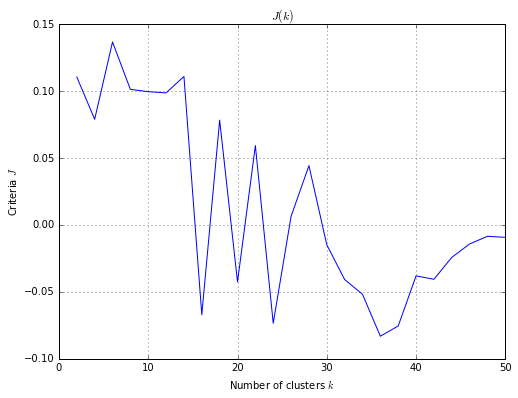

In [13]:
ks = range(2, 51, 2)
criteria = np.zeros(len(ks))

sample = x[np.random.choice(x.shape[0], 1000)]

for i, k in enumerate(ks):
    print k
    cls = Clustering(n_components=k, verbose=0)
    y = cls.fit_predict(sample)
    criteria[i] = quality(sample, y, k)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [14]:
k = 6
cls = Clustering(n_components=k)
y = cls.fit_predict(x)

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 11413
[t-SNE] Computed conditional probabilities for sample 2000 / 11413
[t-SNE] Computed conditional probabilities for sample 3000 / 11413
[t-SNE] Computed conditional probabilities for sample 4000 / 11413
[t-SNE] Computed conditional probabilities for sample 5000 / 11413
[t-SNE] Computed conditional probabilities for sample 6000 / 11413
[t-SNE] Computed conditional probabilities for sample 7000 / 11413
[t-SNE] Computed conditional probabilities for sample 8000 / 11413
[t-SNE] Computed conditional probabilities for sample 9000 / 11413
[t-SNE] Computed conditional probabilities for sample 10000 / 11413
[t-SNE] Computed conditional probabilities for sample 11000 / 11413
[t-SNE] Computed conditional probabilities for sample 11413 / 11413
[t-SNE] Mean sigma: 0.060943
[t-SNE] Error after 100 iterations with early exaggeration: 1.420195
[t-SNE] Error

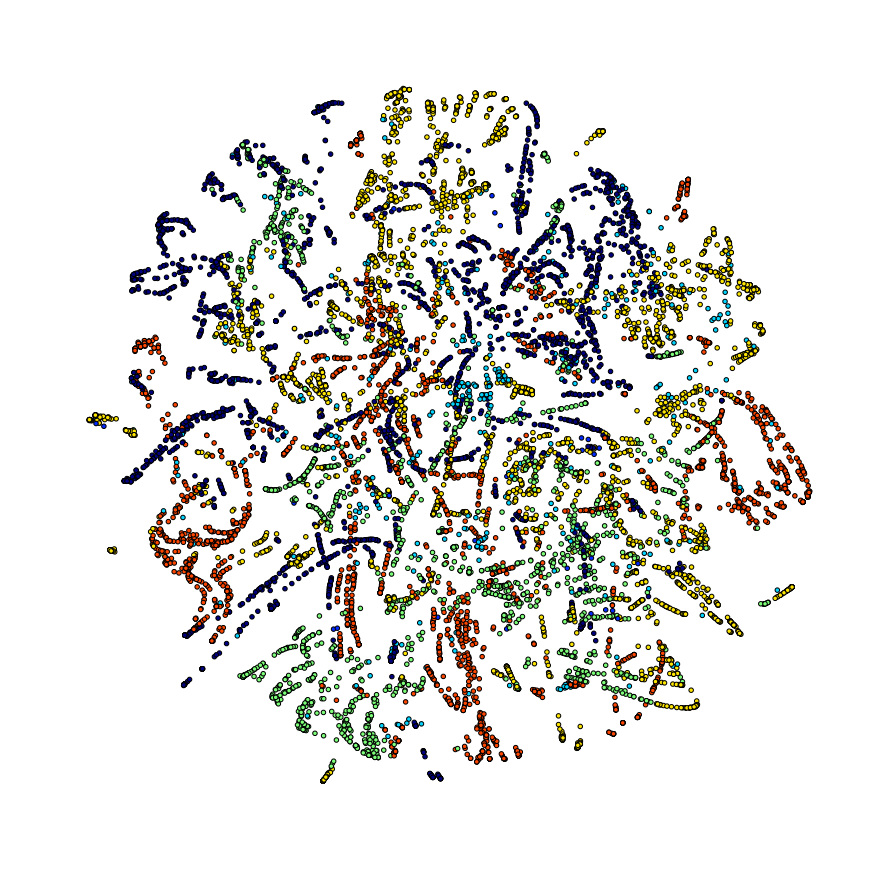

In [19]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

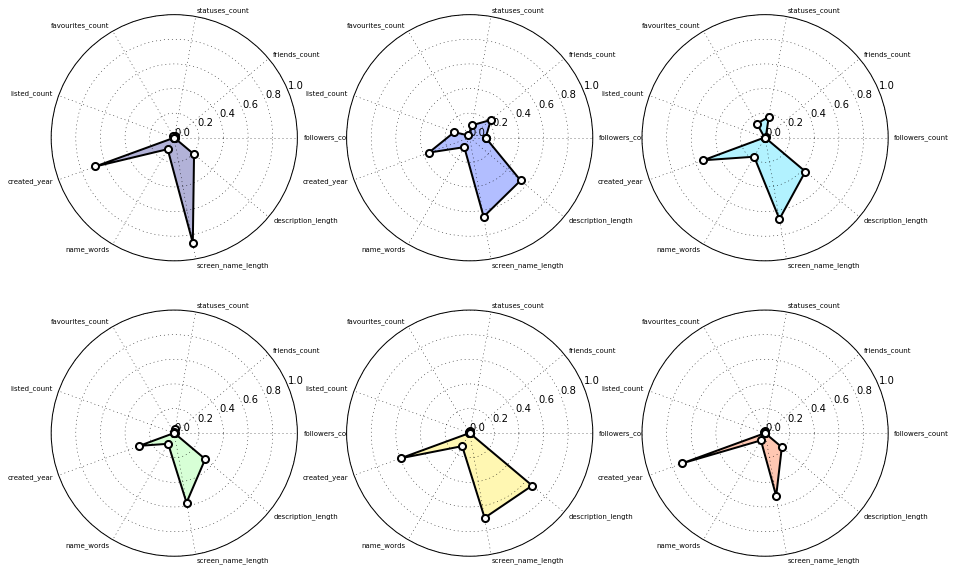

In [20]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.